

## Imports

In [ ]:
!pip install transformers==4.29.2
!pip install rwkv
!pip install yfinance
!pip install torch-summary

In [ ]:
###======= Imports =======###
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from rwkv.model import RWKV
import math
import yfinance as yf


seed = 211
np.random.seed(seed)
torch.manual_seed(seed)



## Custom Rwkv

In [ ]:
### Disclaimer - We took HuggingFace RWKV Model and inserted our changes to it.

# coding=utf-8
# Copyright 2023 Bo Peng and HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""PyTorch RWKV model."""

import math
from dataclasses import dataclass
from pathlib import Path
from typing import List, Optional, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss

from transformers.modeling_utils import PreTrainedModel
from transformers.utils import (
    ModelOutput,
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    is_ninja_available,
    is_torch_cuda_available,
    logging,
)
from transformers.models.rwkv.configuration_rwkv import RwkvConfig
from transformers.models.rwkv.modeling_rwkv import load_wkv_cuda_kernel, RwkvLinearAttention, rwkv_linear_attention_cpu, rwkv_linear_attention, RwkvSelfAttention, RwkvFeedForward, RwkvBlock, RwkvPreTrainedModel, RwkvOutput

rwkv_cuda_kernel = None

class RwkvModel(RwkvPreTrainedModel):
    def __init__(self, config, input_size=6, output_size=1):
        super().__init__(config)

        self.fc1 = nn.Linear(input_size, config.hidden_size)
        self.relu = nn.ReLU()
        self.blocks = nn.ModuleList([RwkvBlock(config, layer_id=idx) for idx in range(config.num_hidden_layers)])
        self.ln_out = nn.LayerNorm(config.hidden_size)
        self.head = nn.Linear(config.hidden_size, output_size) # we want 1 value at the end (prediction)

        self.layers_are_rescaled = False

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embeddings

    def set_input_embeddings(self, new_embeddings):
        self.embeddings = new_embeddings

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        state: Optional[List[torch.FloatTensor]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = True,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, RwkvOutput]:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else (self.config.use_cache if not self.training else False)
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if self.training == self.layers_are_rescaled:
            self._rescale_layers()

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is None and inputs_embeds is None:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        if use_cache and state is None:
            shape = (input_ids.size(0), self.config.hidden_size, self.config.num_hidden_layers)
            state = [
                torch.zeros(
                    *shape, dtype=input_ids.dtype if i <= 1 else torch.float32, device=input_ids.device
                )
                for i in range(5)
            ]
            state[4] -= 1e30

        hidden_states = self.fc1(input_ids)

        hidden_states = self.relu(hidden_states)

        all_self_attentions = () if output_attentions else None
        all_hidden_states = () if output_hidden_states else None
        for idx, block in enumerate(self.blocks):
            hidden_states, state, attentions = block(
                hidden_states, state=state, use_cache=use_cache, output_attentions=output_attentions
            )
            if (
                self.layers_are_rescaled
                and self.config.rescale_every > 0
                and (idx + 1) % self.config.rescale_every == 0
            ):
                hidden_states = hidden_states / 2

            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            if output_attentions:
                all_self_attentions = all_self_attentions + (attentions,)

        hidden_states = self.ln_out(hidden_states)

        hidden_states = self.head(hidden_states)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return (hidden_states, state, all_hidden_states, all_self_attentions)

        return RwkvOutput(
            last_hidden_state=hidden_states,
            state=state,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
        )

    def _rescale_layers(self):
        # Layers should be rescaled for inference only.
        if self.layers_are_rescaled == (not self.training):
            return
        if self.config.rescale_every > 0:
            with torch.no_grad():
                for block_id, block in enumerate(self.blocks):
                    if self.training:
                        block.attention.output.weight.mul_(2 ** int(block_id // self.config.rescale_every))
                        block.feed_forward.value.weight.mul_(2 ** int(block_id // self.config.rescale_every))
                    else:
                        block.attention.output.weight.div_(2 ** int(block_id // self.config.rescale_every))
                        block.feed_forward.value.weight.div_(2 ** int(block_id // self.config.rescale_every))

        self.layers_are_rescaled = not self.training


## Config

In [ ]:
###======= Config Dictionary =======###
config = {
    "data": {
        "window_size": 40,
        "train_split_size": 0.8,
        "val_split_size": 0.1,
        "test_split_size": 0.1
    },
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_test": "#561F78",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_rwkv_layers": 8,
        "hidden_size": 32,
        "dropout": 0.2,
        "context": 20,
    },
    "training": {
        "batch_size": 128,
        "num_epoch": 30,
        "learning_rate": 1e-2,
    }
}

## Data Pre-Processing

[*********************100%***********************]  1 of 1 completed
             Date       Open       High        Low      Close  Adj Close  \
5000   1981-12-04   0.744792   0.757813   0.744792   0.752604   0.251617   
5001   1981-12-07   0.752604   0.757813   0.747396   0.755208   0.252487   
5002   1981-12-08   0.755208   0.757813   0.750000   0.752604   0.251617   
5003   1981-12-09   0.750000   0.750000   0.742188   0.744792   0.249005   
5004   1981-12-10   0.744792   0.755208   0.742188   0.744792   0.249005   
...           ...        ...        ...        ...        ...        ...   
15475  2023-06-26  61.209999  61.290001  60.389999  61.220001  61.220001   
15476  2023-06-27  61.220001  61.360001  60.980000  61.090000  61.090000   
15477  2023-06-28  60.880001  61.040001  60.400002  60.520000  60.520000   
15478  2023-06-29  60.220001  60.349998  59.770000  60.020000  60.020000   
15479  2023-06-30  60.000000  60.349998  59.869999  60.220001  60.220001   

         Volume  


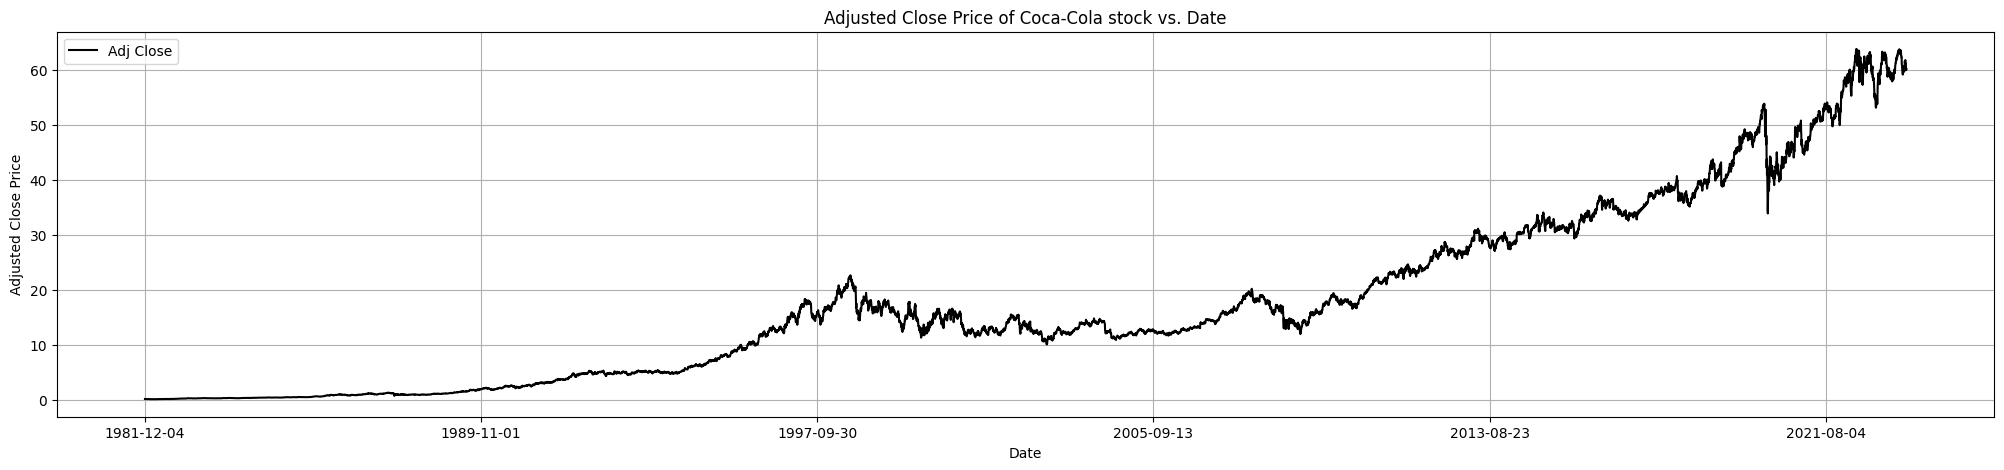

In [ ]:
df_ko = yf.download(tickers="ko")
df_ko.to_csv("KO.csv")
df_ko = pd.read_csv("KO.csv")
df_ko = df_ko[5000:]
print(df_ko)
df_ko.plot(x="Date", y="Adj Close", kind="line", grid=True, color="black", figsize=(25, 5))  # Example for a line plot
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.title("Adjusted Close Price of Coca-Cola stock vs. Date")
plt.show()

In [ ]:
data_df_avgd = df_ko[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].rolling(10).mean()
print(data_df_avgd)
# Drop all rows with NaN values
data_df_avgd.dropna(how='any', axis=0, inplace=True)
data_raw = data_df_avgd.to_numpy()
print(data_raw.shape)
num_data_points = data_raw.shape[0]

         Open    High     Low   Close  Adj Close      Volume
5000      NaN     NaN     NaN     NaN        NaN         NaN
5001      NaN     NaN     NaN     NaN        NaN         NaN
5002      NaN     NaN     NaN     NaN        NaN         NaN
5003      NaN     NaN     NaN     NaN        NaN         NaN
5004      NaN     NaN     NaN     NaN        NaN         NaN
...       ...     ...     ...     ...        ...         ...
15475  61.160  61.491  60.786  61.138  61.000801  16478720.0
15476  61.223  61.562  60.882  61.226  61.134310  15964680.0
15477  61.290  61.599  60.918  61.233  61.187000  15742220.0
15478  61.239  61.526  60.835  61.149  61.149000  16046480.0
15479  61.178  61.431  60.788  61.048  61.048000  16493040.0

[10480 rows x 6 columns]
(10471, 6)


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mm_scaler = MinMaxScaler()
mm_scaler_model = mm_scaler.fit(data_raw)
normalized_data = mm_scaler_model.transform(data_raw)
min_val = mm_scaler.data_min_[4]
mm_scale = mm_scaler.scale_[4]

def inv_transform_minmax(x: np.ndarray):
    return ((x/mm_scale) + min_val)


In [ ]:
def prepare_data_x(x: np.ndarray, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # use the next day as label
    output = x[window_size:]
    return output

def all_cols_to_matrices(data: np.ndarray, window_size):
    num_cols = data.shape[1]
    mat_x = []
    mat_x_unseen = []
    for i in range(num_cols):
        row = data[:,i].T
        row_x, row_x_unseen = prepare_data_x(row, window_size)
        mat_x.append(row_x)
        mat_x_unseen.append(row_x_unseen)
    return np.array(mat_x), np.array(mat_x_unseen)


data_x, data_x_unseen = all_cols_to_matrices(normalized_data, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data, window_size=config["data"]["window_size"])

data_x = np.moveaxis(data_x, 0, 2)

# Split dataset
split_index_train = int(data_y.shape[0] * config["data"]["train_split_size"])
split_index_val = int(data_y.shape[0] * config["data"]["val_split_size"]) + split_index_train


data_x_train = data_x[:split_index_train]
data_x_val =   data_x[split_index_train:split_index_val]
data_x_test =  data_x[split_index_val:]

data_y_train = data_y[:split_index_train]
data_y_val = data_y[split_index_train:split_index_val]
data_y_test = data_y[split_index_val:]


to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)
to_plot_data_y_test = np.zeros(num_data_points)

to_plot_data_y_train[config["data"]["window_size"]:split_index_train+config["data"]["window_size"]] = mm_scaler.inverse_transform(data_y_train)[:, 4]
to_plot_data_y_val[split_index_train+config["data"]["window_size"]:split_index_val+config["data"]["window_size"]] = mm_scaler.inverse_transform(data_y_val)[:, 4]
to_plot_data_y_test[split_index_val+config["data"]["window_size"]:] = mm_scaler.inverse_transform(data_y_test)[:, 4]

In [ ]:
print(data_x.shape)
print(data_x_val.shape)
print(normalized_data.shape)

(10431, 40, 6)
(1043, 40, 6)
(10471, 6)


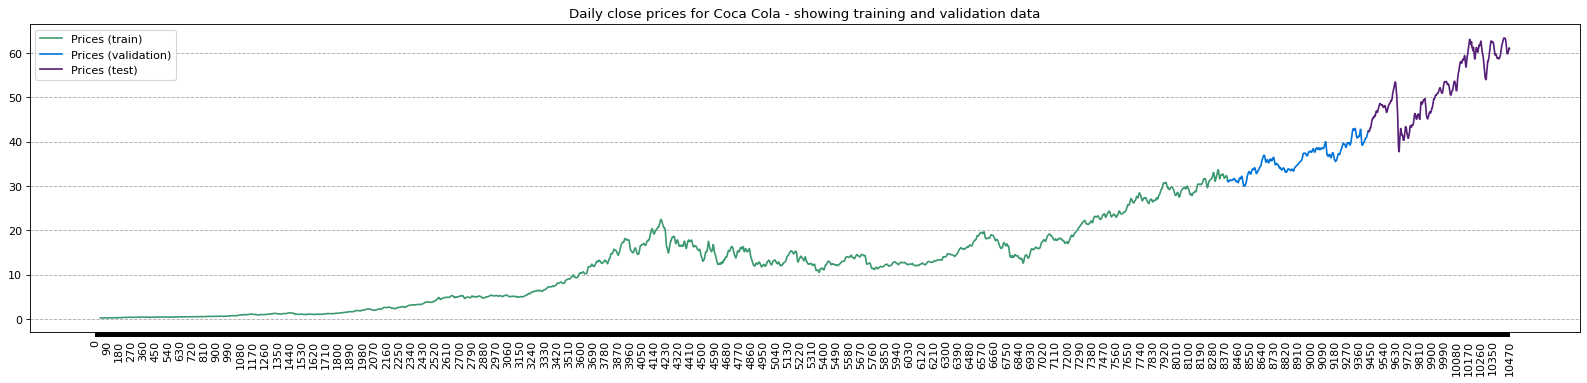

In [ ]:
to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

## plots
data_date = np.arange(to_plot_data_y_train.shape[0])
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
plt.plot(data_date, to_plot_data_y_test, label="Prices (test)", color=config["plots"]["color_test"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close prices for Coca Cola - showing training and validation data")
plt.grid(which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])


dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)
dataset_test = TimeSeriesDataset(data_x_test, data_y_test)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)
print("Test data shape", dataset_test.x.shape, dataset_test.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=config["training"]["batch_size"], shuffle=True)

Train data shape (8344, 40, 6) (8344, 6)
Validation data shape (1043, 40, 6) (1043, 6)
Test data shape (1044, 40, 6) (1044, 6)


## Model definitions and hyper-params

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define RWKV model
rwkv_config = RwkvConfig(vocab_size=0, context_length=config["model"]["context"], hidden_size=config["model"]["hidden_size"], use_cache=False, num_hidden_layers=config["model"]["num_rwkv_layers"])
rwkv_model = RwkvModel(rwkv_config)

In [ ]:
model = rwkv_model
model.to(device)

RwkvModel(
  (fc1): Linear(in_features=6, out_features=32, bias=True)
  (relu): ReLU()
  (blocks): ModuleList(
    (0): RwkvBlock(
      (pre_ln): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (attention): RwkvSelfAttention(
        (time_shift): ZeroPad2d((0, 0, 1, -1))
        (key): Linear(in_features=32, out_features=32, bias=False)
        (value): Linear(in_features=32, out_features=32, bias=False)
        (receptance): Linear(in_features=32, out_features=32, bias=False)
        (output): Linear(in_features=32, out_features=32, bias=False)
      )
      (feed_forward): RwkvFeedForward(
        (time_shift): ZeroPad2d((0, 0, 1, -1))
        (key): Linear(in_features=32, out_features=128, bias=False)
        (receptance): Linear(in_features=32, out_features=32, bias=False)
        (value): Linear(in_features=128, out_features=32, bias=Fals

In [ ]:
# print the model
model_stats = summary(
                model = model,
                dtypes = [torch.float, torch.float],
                batch_dim = 1,
                device = device,
                verbose = 0
                )
print(str(model_stats))

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            224
├─ReLU: 1-2                              --
├─ModuleList: 1-3                        --
|    └─RwkvBlock: 2-1                    --
|    |    └─LayerNorm: 3-1               64
|    |    └─LayerNorm: 3-2               64
|    |    └─LayerNorm: 3-3               64
|    |    └─RwkvSelfAttention: 3-4       4,256
|    |    └─RwkvFeedForward: 3-5         9,280
|    └─RwkvBlock: 2-2                    --
|    |    └─LayerNorm: 3-6               64
|    |    └─LayerNorm: 3-7               64
|    |    └─RwkvSelfAttention: 3-8       4,256
|    |    └─RwkvFeedForward: 3-9         9,280
|    └─RwkvBlock: 2-3                    --
|    |    └─LayerNorm: 3-10              64
|    |    └─LayerNorm: 3-11              64
|    |    └─RwkvSelfAttention: 3-12      4,256
|    |    └─RwkvFeedForward: 3-13        9,280
|    └─RwkvBlock: 2-4                    --
|    |    └─LayerNorm: 3-14              64
|    |  

In [ ]:
epochs = 30
criterion = nn.MSELoss()
optimizer = torch.optim.RAdam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.6, threshold=1e-5, min_lr=1e-7, verbose=True, patience=1)

## Training and Evaluation

In [ ]:
def evaluate(data_loader, epoch):
    data_iterator = iter(data_loader)
    nb_batches = len(data_loader)
    model.eval()
    acc = 0
    losses = 0.0
    with torch.no_grad():
      for _, (x, y) in enumerate(data_iterator):
          x = x.to(device)
          y = y.to(device)
          out = model(x)
          out = out.last_hidden_state[:,-1,0]
          loss = criterion(out, y[:, 4].contiguous())
          losses += loss.item()

    val_loss = losses / nb_batches
    print('-' * 50)
    print(f'| end of epoch {epoch:3d} | '
             f'valid loss {val_loss:5.6f} ')
    print('-' * 50)

    return val_loss


def train(train_loader, valid_loader):

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_iterator, valid_iterator = iter(train_loader), iter(valid_loader)
        nb_batches_train = len(train_loader)
        train_acc = 0
        model.train()
        losses = 0.0

        for idx, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            out = out.last_hidden_state[:,-1,0]
            loss = criterion(out, y[:, 4].contiguous())

            optimizer.zero_grad()

            loss.backward()
            losses += loss.item()

            optimizer.step()

        train_loss = losses / nb_batches_train

        print(f'| epoch {epoch:3d} | '
              f'train loss {train_loss:5.6f} ')

        val_loss = evaluate(valid_loader, epoch)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Step scheduler
        scheduler.step(val_loss)

    return train_losses, val_losses



# Training

In [ ]:
t_l, v_l = train(train_dataloader, val_dataloader)

| epoch   0 | train loss 0.014607 
--------------------------------------------------
| end of epoch   0 | valid loss 0.007763 
--------------------------------------------------
| epoch   1 | train loss 0.000277 
--------------------------------------------------
| end of epoch   1 | valid loss 0.004045 
--------------------------------------------------
| epoch   2 | train loss 0.000127 
--------------------------------------------------
| end of epoch   2 | valid loss 0.000191 
--------------------------------------------------
| epoch   3 | train loss 0.000151 
--------------------------------------------------
| end of epoch   3 | valid loss 0.000605 
--------------------------------------------------
| epoch   4 | train loss 0.000338 
--------------------------------------------------
| end of epoch   4 | valid loss 0.000118 
--------------------------------------------------
| epoch   5 | train loss 0.000276 
--------------------------------------------------
| end of epoch   5 

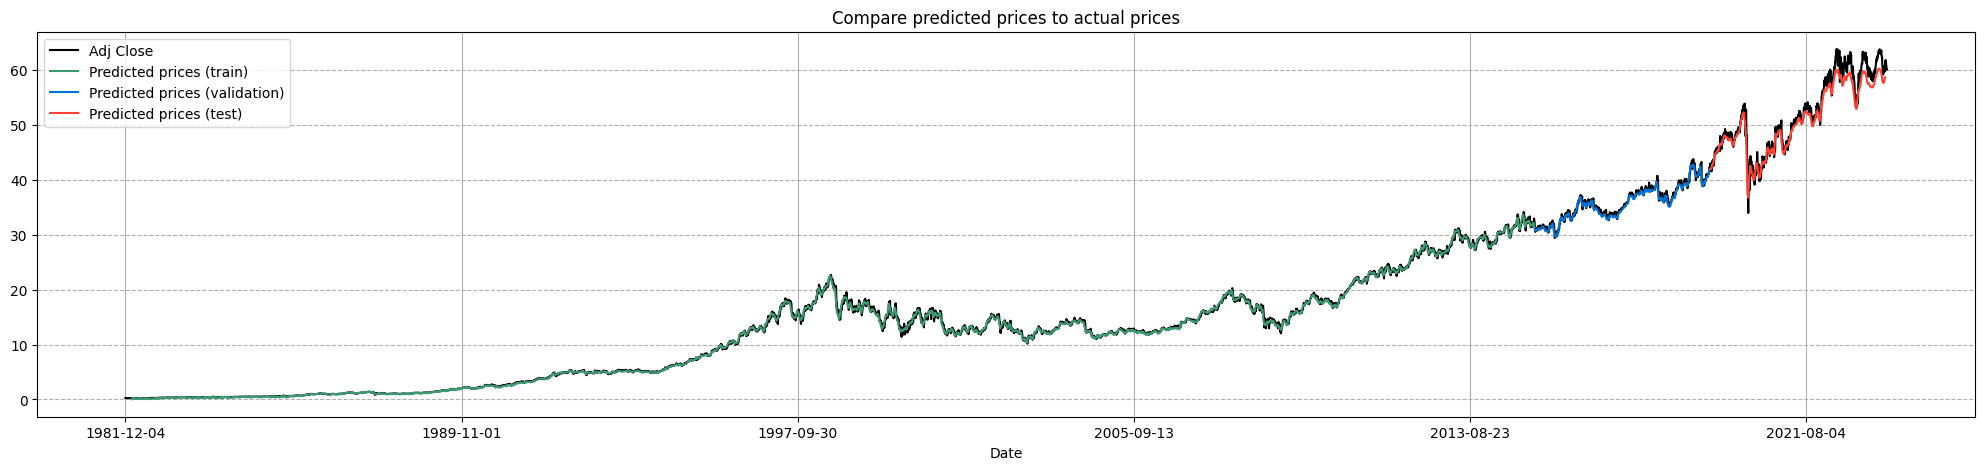

In [ ]:
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=config["training"]["batch_size"], shuffle=False)


model.eval()
# predict on the training data, to see how well the model managed to learn and memorize
with torch.no_grad():
  predicted_train = np.array([])

  for idx, (x, y) in enumerate(train_dataloader):
      x = x.to(device)
      out = model(x)
      out = out.last_hidden_state[:,-1,0]
      out = out.cpu().detach().numpy()
      predicted_train = np.concatenate((predicted_train, out))

  # predict on the validation data, to see how the model does

  predicted_val = np.array([])

  for idx, (x, y) in enumerate(val_dataloader):
      x = x.to(device)
      out = model(x)
      out = out.last_hidden_state[:,-1,0]
      out = out.cpu().detach().numpy()
      predicted_val = np.concatenate((predicted_val, out))


  # predict on the test data, to see how the model does

  predicted_test = np.array([])

  for idx, (x, y) in enumerate(test_dataloader):
      x = x.to(device)
      out = model(x)
      out = out.last_hidden_state[:,-1,0]
      out = out.cpu().detach().numpy()
      predicted_test = np.concatenate((predicted_test, out))


# prepare data for plotting

to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)
to_plot_data_y_test_pred = np.zeros(num_data_points)

to_plot_data_y_train_pred[config["data"]["window_size"]:split_index_train+config["data"]["window_size"]] = inv_transform_minmax(predicted_train)
to_plot_data_y_val_pred[split_index_train+config["data"]["window_size"]:split_index_val+config["data"]["window_size"]] = inv_transform_minmax(predicted_val)
to_plot_data_y_test_pred[split_index_val+config["data"]["window_size"]:] = inv_transform_minmax(predicted_test)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

# plots
data_date = np.arange(to_plot_data_y_train.shape[0])
df_ko.plot(x="Date", y="Adj Close", kind="line", grid=True, color="black", figsize=(25, 5))  # Example for a line plot
plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.plot(data_date, to_plot_data_y_test_pred, label="Predicted prices (test)", color=config["plots"]["color_pred_test"])
plt.title("Compare predicted prices to actual prices")
plt.grid(which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

## Viewing results

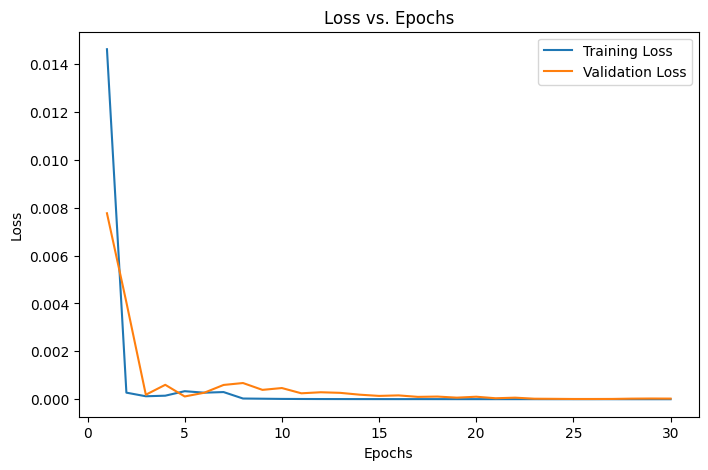

In [ ]:
# plot loss functions
epochs_list = np.arange(1, epochs + 1)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.set_title("Loss vs. Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.plot(epochs_list, t_l, label='Training Loss')
ax.plot(epochs_list, v_l, label='Validation Loss')
ax.legend()
plt.show()

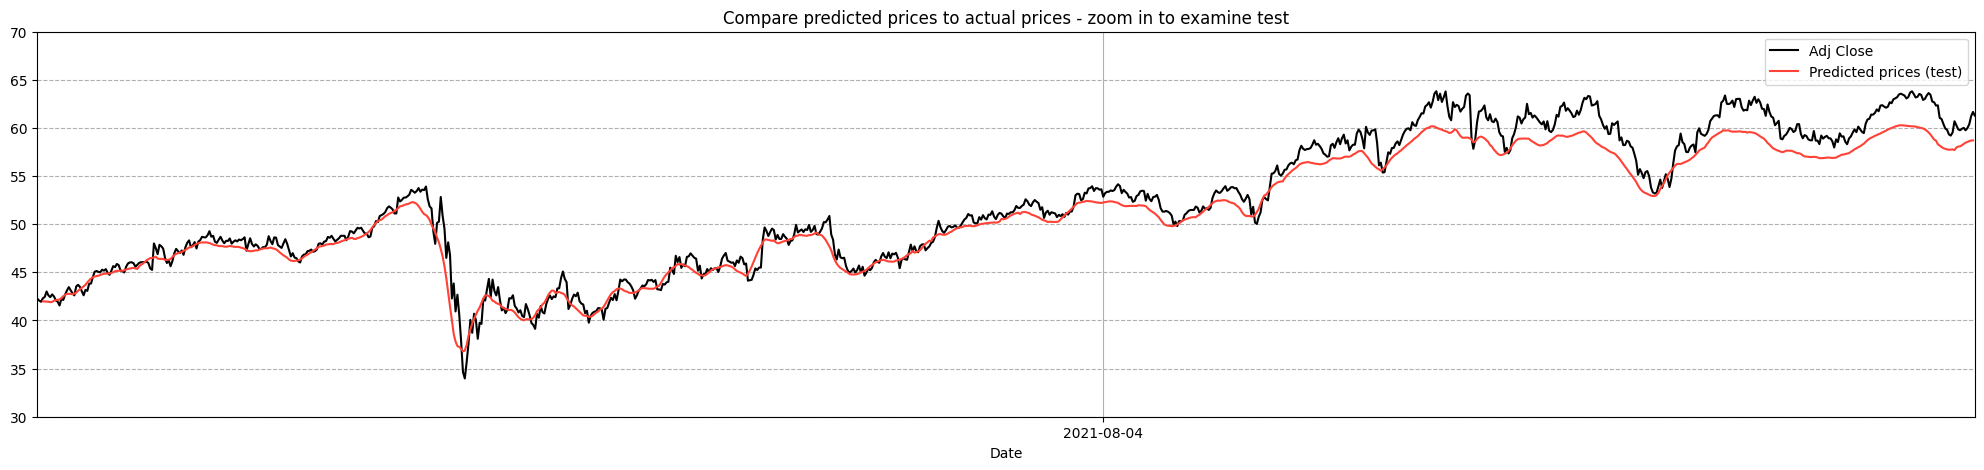

In [ ]:
# plots
data_date = np.arange(to_plot_data_y_train.shape[0])
df_ko.plot(x="Date", y="Adj Close", kind="line", grid=True, color="black", figsize=(25, 5))  # Example for a line plot
plt.plot(data_date, to_plot_data_y_test_pred, label="Predicted prices (test)", color=config["plots"]["color_pred_test"])
plt.title("Compare predicted prices to actual prices - zoom in to examine test")
plt.xlim(np.ceil(to_plot_data_y_train.shape[0] * 0.9), np.ceil(to_plot_data_y_train.shape[0] * 1))
plt.ylim(30, 70)
plt.grid(which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

In [ ]:
# Print test loss
test_loss = evaluate(test_dataloader, -1)
print(f"Test Loss: {test_loss}")

--------------------------------------------------
| end of epoch  -1 | valid loss 0.000623 
--------------------------------------------------
Test Loss: 0.0006225011141699118
